In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath("../.."))
for item in sys.path:
	print(item)

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code
/home/kian/anaconda3/envs/thesis2/lib/python311.zip
/home/kian/anaconda3/envs/thesis2/lib/python3.11
/home/kian/anaconda3/envs/thesis2/lib/python3.11/lib-dynload

/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import matplotlib.pyplot as plt

from datetime import datetime
import time
import json

import Double_Pendulum.robot_parameters as robot_parameters
import Double_Pendulum.transforms as transforms
import Double_Pendulum.dynamics as dynamics

import training_data as training_data
import Plotting.theta_visualiser as theta_visualizer

import autoencoders

from functools import partial

%load_ext autoreload
%autoreload 2

/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
rp["m0"] = 0.0
print(rp)

train_clockwise = False

cpu
{'l0': 2.5, 'l1': 2.5, 'm0': 0.0, 'm1': 3.0, 'g': 9.81, 'xa': 2.0, 'ya': 5}


In [4]:
def mask_points(q0_split, clockwise = False):

	"""
	Returns a set of [q0, q1] points based on "q0_split" limits on q0 and q1.
	The limits on q1 depend on whether a clockwise or counterclockwise dataset is selected.
	"""   

	# Retrieve training points
	points = training_data.points.to(device)
	
	# Mask to retrieve only the counterclockwise points
	width_mask = (points[:,0] >= q0_split[0]) & (points[:,0] <= q0_split[1])
	ccw_mask = ((points[:,1] >= points[:,0]) & 
				  (points[:,1] <= points[:,0] + torch.pi))
	
	# Mask to retrieve only the clockwise points
	cw_mask = ((points[:,1] >= points[:,0] - torch.pi) & (points[:,1] <= points[:,0]))

	if clockwise:
		final_mask = width_mask & cw_mask
	else:
		final_mask = width_mask & ccw_mask
	
	points = points[final_mask]
	points = points[0:6000]

	if points.size(0) < 6000:
		print("Warning: Only", points.size(0), "points in dataset.")

	return(points)

In [5]:
def points_plotter(points, extend = None, save = False, file_path = None):

	""" 
	Simple plotter function which visualizes the points used for training of the Autoencoder. 
	"""
	 
	plt.figure(figsize=(6, 6))
	plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
	plt.title('Scatter Plot of q0 vs q1')
	plt.xlabel('q0')
	plt.ylabel('q1')
	plt.xlim(-2*torch.pi, 2*torch.pi)
	plt.ylim(-2*torch.pi, 2*torch.pi)
	plt.grid(True)
	
	if save:
		plt.savefig(file_path, dpi=800)
	plt.show()

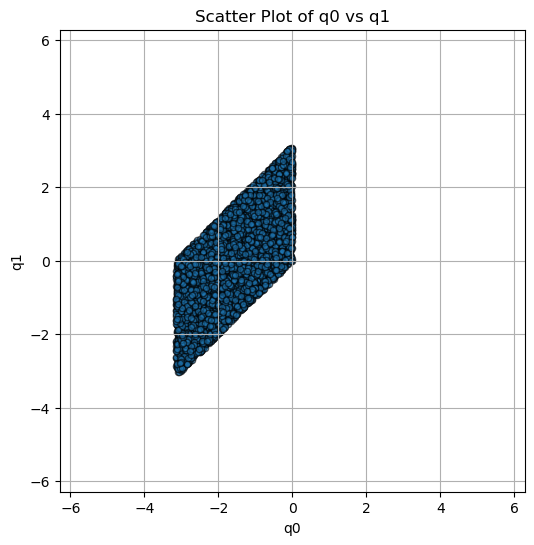

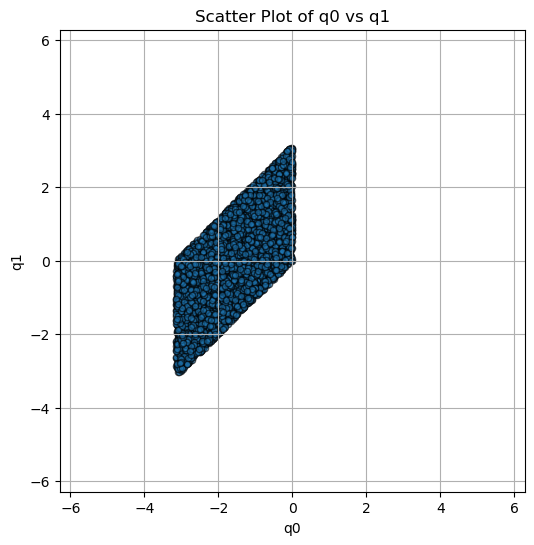

In [6]:
masked_points = mask_points((-torch.pi, torch.pi), clockwise = train_clockwise)
deshifted_points = transforms.wrap_to_pi(masked_points.clone())
points_plotter(masked_points, extend="ccw")
points_plotter(deshifted_points, extend="ccw")

In [7]:


def make_dataset(points):

	"""
	Compute mass- and input matrix of all training points to reduce load in training.
	Returns TensorDataset of (q, M_q, A_q). 
	"""

	data_pairs = []
	for point in points:
		Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
		Aq_point = dynamics.input_matrix(rp, point)
		data_pairs.append((point, Mq_point, Aq_point))

	points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
	mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
	input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

	# Create TensorDataset
	dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
	return(dataset)


In [8]:
def make_dataloaders(dataset, batch_size = 512, train_part = 0.7):

	"""
	Creates a training and validation dataloader from an input dataset, based on 
	batch size and the ratio train_part. 
	"""

	train_size = int(train_part * len(dataset))
	val_size = len(dataset) - train_size

	# Create TensorDataset for both training and testing sets
	train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

	# Create the DataLoader for both training and testing sets
	train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
	val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

	return(train_dataloader, val_dataloader)

In [9]:
import torch.nn.functional as F

def loss_fun(q, theta, q_hat, M_q, A_q, J_h_enc, J_h_dec):

	"""
	Loss function for training the Autoencoder. Loss terms are the following:
	l_recon:    Loss between input- and reconstructed variable. (MSE)
	l_off_dia:  Loss of off-diagonal terms of mass matrix in theta-space. (MSE)
	l_dia:      Loss on diagonal terms of mass matrix in theta-space. 
				(mean of normalized negative log-loss)
	l_input:    Loss to drive input matrix in theta-space to [1, 0]^T (MSE)

	"""

	l_recon = F.mse_loss(q, q_hat, reduction="mean")

	# Calculate forward and inverse Jacobians
	J_h = J_h_enc
	J_h_trans = torch.transpose(J_h, 1, 2)
	J_h_inv = J_h_dec
	J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

	M_th = J_h_inv_trans @ M_q @ J_h_inv
	A_th = J_h_inv_trans @ A_q

	# Loss inspired by Pietro Pustina's paper on input decoupling:
	# https://arxiv.org/pdf/2306.07258
	l_input_jac = F.mse_loss(J_h[:, 0, :], A_q[:, :, 0], reduction="mean")

	l_J_eye = F.mse_loss( torch.bmm(J_h, J_h_inv), 
						torch.eye(2,device=J_h.device).unsqueeze(0).repeat(J_h.size(0),1,1),
						reduction='mean' )

	# Loss on the first coordinate theta, again from Pietro Pustina's analytic formulation
	theta_ana = torch.vmap(transforms.analytic_theta, in_dims = (None, 0))(rp, q)
	l_theta = F.mse_loss(theta[:, 0], theta_ana[:, 0], reduction="mean")

	# Enforce inertial decoupling
	l_off_diag = torch.mean((M_th[:, 0, 1])**2)
	diag_values = torch.diagonal(M_th, dim1=1, dim2=2)
	l_diag = torch.mean((-1 + torch.exp(-(diag_values - 1))) * (diag_values < 1).float())  # Shape: (batch_size, 2)

	## input decoupling loss
	#l_input = torch.mean((A_th[:, 1]**2)) + torch.mean(((A_th[:, 0]-1)**2))
	l_input = torch.mean((A_th[:, 1]**2))
	
	
	loss_terms = torch.stack([l_recon, l_diag, l_off_diag, 
							   l_input, l_input_jac, l_theta, l_J_eye])
	loss_sum = l_recon + l_diag + l_off_diag + l_input + l_input_jac + l_theta + l_J_eye

	return loss_sum, loss_terms

In [10]:

#model.load_state_dict(torch.load(load_path, weights_only=True))

def load_model(current_time, num_epochs, lr, dir_name = None):
	if dir_name is None:
		model = autoencoders.Autoencoder_double(rp).to(device)  # Move model to GPU
		dir_name = f"NN_{current_time}"
		file_counter = 0
	else:
		dir_path = os.path.join(os.getcwd(), "Models", dir_name)
		nn_filename = dir_name + "_0.pth"
		nn_filepath = os.path.join(dir_path, nn_filename)
		file_counter = 0
		while os.path.isfile(nn_filepath):
			print("Looking for latest weights and bias file.")
			file_counter += 1
			nn_filename = nn_filename[:-6] + "_" + str(file_counter) + ".pth"
			nn_filepath = os.path.join(dir_path, nn_filename)

		model_path = os.path.join("Models", dir_name, dir_name + "_" + str(file_counter-1) + ".pth")
		model = autoencoders.Autoencoder_double(rp).to(device)  # Initialize model architecture
		model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))  # Load weights

	return model, file_counter, dir_name


In [11]:
def make_metadata(q0_split, lr, num_epochs, nn_filename, model, file_counter, dir_path):
	
	metadata = {"q0_low" : q0_split[0],
				"q0_high" : q0_split[1],
				"lr" : lr,
				"epochs" : num_epochs,
				"file_name" : nn_filename,
				#"loss_weights": {
				#	"f_recon": f_recon,
				#	"f_diag": f_diag,
				#	"f_off_diag": f_off_diag,
				#	"f_input": f_input,
				#	"f_input_jac": f_input_jac,
				#	"f_theta": f_theta,
				#	"f_J_eye": f_J_eye
				}#}
	metadata["architecture"] = {
		"encoder": autoencoders.summarize_sequential(model.enc),
		"decoder": autoencoders.summarize_sequential(model.dec)
	}

	metadata_filename = "metadata_" + str(file_counter) + ".json"
	metadata_filepath = os.path.join(dir_path, metadata_filename)
	with open(metadata_filepath, "w") as f:
		json.dump(metadata, f, indent=4)


In [ ]:
def train_AE_model(rp, device, lr, num_epochs, q0_split, train_dataloader, val_dataloader, current_time, dir_name = None):

	"""
	Executes training loop for autoencoder
	"""




	model, file_counter, dir_name = load_model(current_time, num_epochs, lr, dir_name)

	optimizer = torch.optim.Adam(model.parameters(), lr=lr)#,  weight_decay=1e-6)
	scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))
     
	dir_path = os.path.join(os.getcwd(), "Models", dir_name)
	os.makedirs(dir_path, exist_ok=True)
	nn_filename = dir_name + "_" + str(file_counter) + ".pth"
	nn_filepath = os.path.join(dir_path, nn_filename)


	# Set-up for Gradnorm learning of weights
	n_tasks = 7
	loss_weights = nn.Parameter(torch.ones(n_tasks, device=device), requires_grad=True)
	weight_history = []

	initial_task_losses = None
	shared_parameters = list(model.enc[-1].parameters())

	alpha = 1.5

	optimizer_w = torch.optim.Adam([loss_weights],    lr=1e-3)

	make_metadata(q0_split, lr, num_epochs, nn_filename, model, file_counter, dir_path)

	train_losses = []
	val_losses = []
	val_loss_terms_list = [] #Trying something new
	start_time = time.time()  

	for epoch in range(num_epochs):

		# Training phase
		model.train()
		train_loss = 0
		train_loss_terms = torch.zeros(n_tasks, device=device)
		train_loss_raw = 0
		train_loss_terms_raw = torch.zeros(n_tasks, device=device)
		for index, (q, M_q, A_q) in enumerate(train_dataloader):

			optimizer.zero_grad()
			optimizer_w.zero_grad()

			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			batch_size = q.size(0)
			
			theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)  
			theta_ana = model.theta_ana(q)
					
			raw_loss, raw_losses = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)

			if initial_task_losses is None:
				# Detach so this never tracks gradients, and clone so it's own storage
				initial_task_losses = raw_losses.detach().clone()
			
			weighted_losses = loss_weights * raw_losses
			loss = weighted_losses.sum()
			optimizer.zero_grad()
			loss.backward(retain_graph=True)

			train_loss += loss.item() * batch_size
			train_loss_terms += weighted_losses * batch_size
			train_loss_raw += raw_loss.item() * batch_size
			train_loss_terms_raw += raw_losses * batch_size

			G = []
			for i in range(n_tasks):
				# ∇_shared (w_i * L_i)
				grads = torch.autograd.grad(loss_weights[i] * raw_losses[i],
									shared_parameters,
									retain_graph=True,
									create_graph=True)
				# Flatten & L2 norm
				grad_norm = torch.norm(torch.stack([g.norm() for g in grads]))
				G.append(grad_norm)
			G = torch.stack(G)

			with torch.no_grad():
				loss_ratios = raw_losses.detach() / initial_task_losses
				mean_ratio  = loss_ratios.mean()
				r = loss_ratios / mean_ratio

			# The target norm: G̅(t) * [r_i(t)]^α, where G̅ = mean_j[G_j]
			G_bar = G.mean().detach()
			G_target = G_bar * (r ** alpha)

			# Build the GradNorm loss and step on w 
			gradnorm_loss = torch.mean(torch.abs(G - G_target))

			optimizer_w.zero_grad()
			gradnorm_loss.backward()

			optimizer.step()
			optimizer_w.step()

			

			with torch.no_grad():
				loss_weights.data *= n_tasks / loss_weights.data.sum()

		train_loss /= len(train_dataloader.dataset) 
		train_loss_terms /= len(train_dataloader.dataset) 
		train_loss_raw /= len(train_dataloader.dataset) 
		train_loss_terms_raw /= len(train_dataloader.dataset) 
		train_losses.append(train_loss)

		# Validation phase
		model.eval()
		val_loss = 0
		val_loss_terms = torch.zeros(n_tasks, device = device)
		with torch.no_grad():
			for index, (q, M_q, A_q) in enumerate(val_dataloader):
				q = q.to(device)
				M_q = M_q.to(device)
				A_q = A_q.to(device)

				batch_size = q.size(0)

				theta, J_h, q_hat, J_h_dec, J_h_ana = model.forward(q)
				theta_ana = model.theta_ana(q)

				_, raw_losses = loss_fun(q, theta, q_hat, M_q, A_q, J_h, J_h_dec)
				weighted_losses = loss_weights * raw_losses
				loss = weighted_losses.sum()
				val_loss += loss.item() * batch_size
				val_loss_terms += weighted_losses * batch_size

		val_loss /= len(val_dataloader.dataset)
		val_loss_terms /= len(val_dataloader.dataset)

		val_losses.append(val_loss)
		val_loss_terms_list.append(val_loss_terms.cpu().numpy())
		epoch_duration = time.time() - start_time
		scheduler.step()

		weight_history.append(loss_weights.detach().cpu().numpy().copy())
		
		tlt = train_loss_terms
		print(
			f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds')
		print(
			f'l_recon: {tlt[0]:.4f}, l_diag: {tlt[1]:.4f}, l_off_diag: {tlt[2]:.4f}, l_input: {tlt[3]:.4f}, l_input_jac: {tlt[4]:.4f}, l_theta: {tlt[5]:.4f}, l_J_eye: {tlt[6]:.4f}'
		)

	weight_history = np.stack(weight_history)  # shape: (num_steps, n_tasks)		
	return(model, train_losses, val_losses, dir_path, nn_filepath, file_counter, weight_history)


In [17]:
def save_model(model, file_path):
	torch.save(model.state_dict(), file_path)
	print(f"Model parameters saved to {file_path}")


In [18]:
def plot_loss(train_losses, val_losses, log = False, save = False, file_path = None):

	"""
	Plots training and validation loss. 
	ylim" and "yscale" should be enabled depending on the loss function.
	"""

	plt.figure(figsize=(10, 6))
	plt.plot(train_losses, label="Training Loss")
	plt.plot(val_losses, label="Validation Loss")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	#plt.ylim((-1, 40))
	plt.legend()
	plt.title("Training and Validation Loss over Epochs")
	plt.grid(True)
	if log:
		plt.yscale("log")
	if save:
		plt.savefig(file_path, dpi=800)
	plt.show()


In [19]:
import Plotting.plotters_simple as plotters_simple

def make_plot_dataloader(dataset):

	"""
	Takes the training dataset and returns a dataloader of every 10th point
	to reduce visual clutter. 
	"""

	points_tensor, mass_matrices_tensor, input_matrices_tensor = dataset.tensors
	
	plot_sampled = points_tensor[::10]
	mass_sampled = mass_matrices_tensor[::10]
	input_sampled = input_matrices_tensor[::10]

	plot_dataset = TensorDataset(plot_sampled, mass_sampled, input_sampled)
	plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

	return(plot_dataloader)

In [20]:
def plot_model_performance(model, plot_dataloader, folder_path):

	model_ana = autoencoders.Analytic_transformer(rp)

	os.makedirs(folder_path, exist_ok=True)

	model.eval()
	with torch.no_grad():
		for (q, M_q, A_q) in plot_dataloader:
			q = q.to(device)
			M_q = M_q.to(device)
			A_q = A_q.to(device)

			theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
			theta_ana = model.theta_ana(q)
			J_h_trans = torch.transpose(J_h, 1, 2)
			J_h_inv = J_h_dec
			J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

			J_h_inv_ana = torch.linalg.inv(J_h_ana)
			J_h_inv_trans_ana = torch.transpose(J_h_inv_ana, 1, 2)

			M_th = J_h_inv_trans @ M_q @ J_h_inv
			A_th = (J_h_inv_trans @ A_q).squeeze(-1)

			M_th_ana = J_h_inv_trans_ana @ M_q @ J_h_inv_ana
			A_th_ana = (J_h_inv_trans_ana @ A_q).squeeze(-1)

			
			plotters_simple.plot_3d_quad(q, [theta_ana[:, 0], theta[:, 0], theta_ana[:, 1], theta[:, 1]], "Analytic vs learned theta", 
										 ["th0_ana", "th0_learned", "th_1_ana", "th_1_learned"], "q_0", "q_1", "th", folder_path)
			


			plotters_simple.plot_3d_double(q, [A_th[:, 0], A_th[:, 1]], "Input decoupling", ["A0", "A1"], "q_0", "q_1", "A", folder_path)
			
			A_th = A_th.cpu().detach().numpy()
			print("Percentage of abs(A_0) > 0.6:", 100 * np.sum(np.abs(A_th[:, 0]) > 0.6)/A_th[:, 0].size, "%")
			print("Percentage of abs(A_1) < 0.3:", 100 * np.sum(np.abs(A_th[:, 1]) < 0.3)/A_th[:, 1].size, "%")
			
			plotters_simple.plot_3d_quad(q, [M_th[:, 0, 0], M_th[:, 0, 1], M_th[:, 1, 0], M_th[:, 1, 1]], "M_th vs q", 
										 ["M_th[0,0]", "M_th[0,1]", "M_th[1,0]", "M_th[1,1]"], "q_0", "q_1", "M_th", folder_path)
			M_th_cpu = M_th.cpu().detach().numpy()
			print("Percentage of abs(M_00) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 0]) > 1.0)/M_th_cpu[:, 0, 0].size, "%")
			print("Percentage of abs(M_01) < 0.2:", 100 * np.sum(np.abs(M_th_cpu[:, 0, 1]) < 0.2)/M_th_cpu[:, 0, 1].size, "%")
			print("Percentage of abs(M_11) > 1.0:", 100 * np.sum(np.abs(M_th_cpu[:, 1, 1]) > 1.0)/M_th_cpu[:, 1, 1].size, "%")


			#plotters_simple.plot_3d_double(q, J_h_ana[:, 0, 0], J_h[:, 0, 1], "J_h", "00", "01", "q_0", "q_1", "J_h", device)
			#plotters_simple.plot_3d_double(q, J_h_ana[:, 1, 0], J_h[:, 1, 1], "J_h", "10", "11", "q_0", "q_1", "J_h", device)
		

In [22]:
q0_split = (-torch.pi, torch.pi)
batch_size = 512
train_part = 0.7

rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 101
lr = 1e-3

# IMPORTANT:
# If you want to train on an existing model
#existing_model_name = "NN_202505131531"
existing_model_name = None

plt.ion()

current_time = datetime.now().strftime("%Y%m%d%H%M")

shifted_points = mask_points(q0_split, clockwise=train_clockwise)

dataset = make_dataset(shifted_points)
(train_dataloader, val_dataloader) = make_dataloaders(dataset=dataset, batch_size=batch_size, train_part=train_part)
outputs = []
model, train_losses, val_losses, dir_path, nn_filepath, file_counter, weight_history = train_AE_model(rp, device, lr, num_epochs, q0_split, train_dataloader, 
														val_dataloader, current_time, existing_model_name)

Epoch [1/101], Training Loss: 48.5415, Validation Loss: 39.0959, Duration: 1.01 seconds
l_recon: 21.1560, l_diag: 0.8721, l_off_diag: 0.0000, l_input: 0.0000, l_input_jac: 1.3895, l_theta: 24.8697, l_J_eye: 0.2541
Epoch [2/101], Training Loss: 37.5205, Validation Loss: 35.1674, Duration: 1.97 seconds
l_recon: 15.6609, l_diag: 0.7652, l_off_diag: 0.0000, l_input: 0.0000, l_input_jac: 1.2196, l_theta: 19.6520, l_J_eye: 0.2229
Epoch [3/101], Training Loss: 33.7757, Validation Loss: 31.7085, Duration: 2.84 seconds
l_recon: 13.5779, l_diag: 0.7756, l_off_diag: 0.0000, l_input: 0.0001, l_input_jac: 1.2374, l_theta: 17.9589, l_J_eye: 0.2259
Epoch [4/101], Training Loss: 30.4877, Validation Loss: 28.6612, Duration: 3.90 seconds
l_recon: 11.8370, l_diag: 0.7852, l_off_diag: 0.0000, l_input: 0.0001, l_input_jac: 1.2544, l_theta: 16.3823, l_J_eye: 0.2288
Epoch [5/101], Training Loss: 27.5957, Validation Loss: 25.9630, Duration: 4.70 seconds
l_recon: 10.3828, l_diag: 0.7946, l_off_diag: 0.0000, l_

(101, 7)


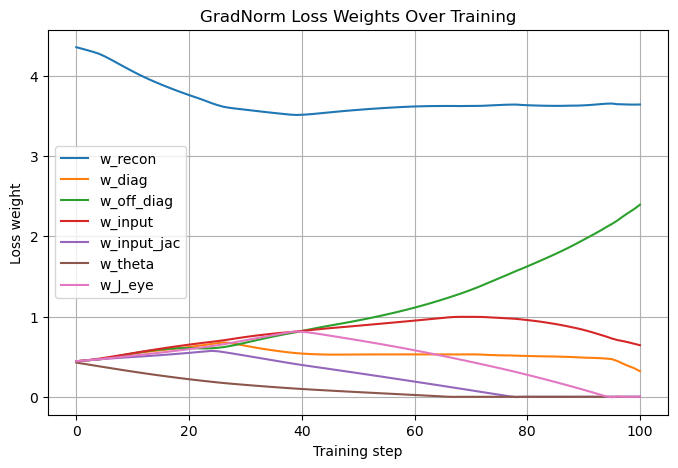

In [25]:
steps = np.arange(weight_history.shape[0])
print(weight_history.shape)
plt.figure(figsize=(8,5))
labels = ["w_recon", "w_diag", "w_off_diag", "w_input", "w_input_jac", "w_theta", "w_J_eye"]
for i in range(weight_history.shape[1]):
	plt.plot(steps, weight_history[:, i], label=labels[i])
plt.xlabel("Training step")
plt.grid()
plt.ylabel("Loss weight")
plt.legend()
plt.title("GradNorm Loss Weights Over Training")
plt.show()

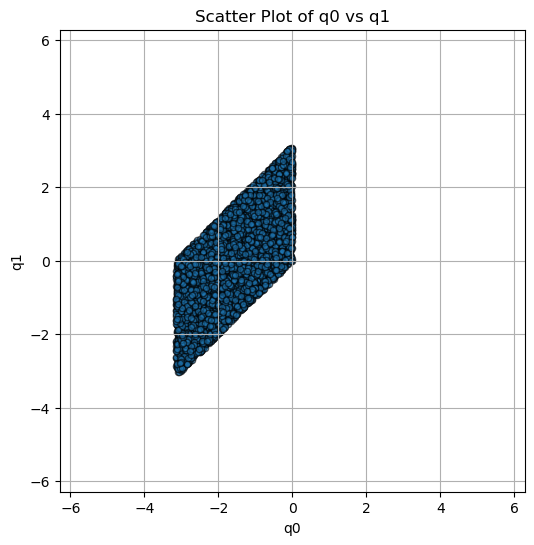

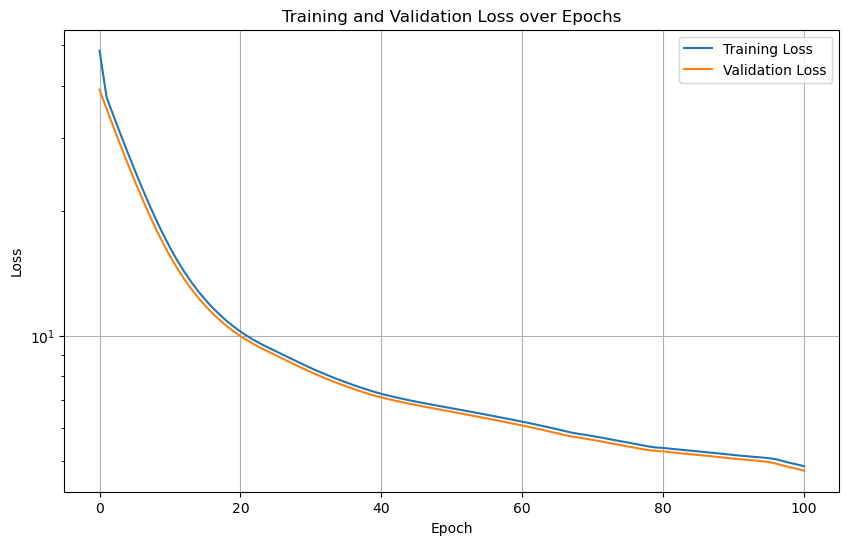

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Double_Pendulum/Learning/Models/NN_202505142158/NN_202505142158_0.pth
/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Double_Pendulum/Learning/Models/NN_202505142158/NN_202505142158_0.pth


In [26]:
points_path = os.path.join(dir_path, "training_points_" + str(file_counter) + ".png")
points_plotter(shifted_points, save = True, file_path = points_path)
scatter_fig_path = os.path.join(dir_path, "loss_" + str(file_counter) + ".png")
plot_loss(train_losses, val_losses, log = True, save = True, file_path = scatter_fig_path)
save_model(model, nn_filepath)
print(nn_filepath)

q: torch.Size([2500, 2])
theta: torch.Size([2500, 2])


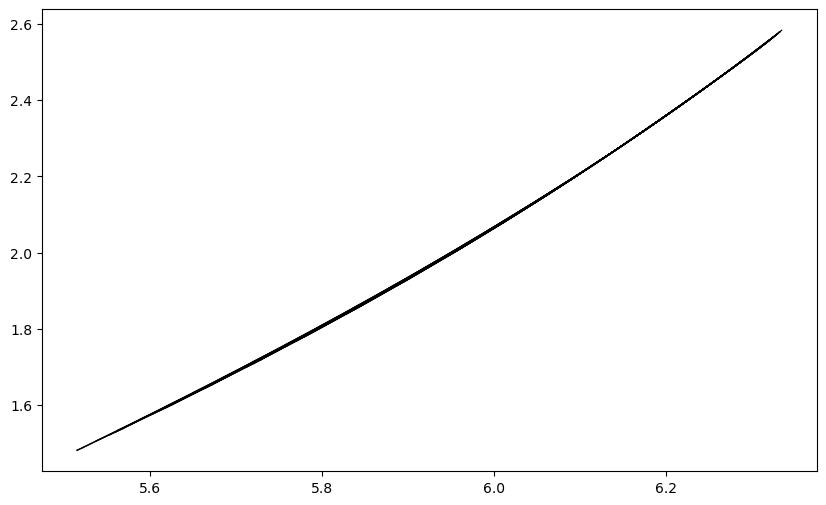

In [27]:
def theta_0_single(model, q):
	print("q:", q.size())
	theta = model.encoder(q)
	print("theta:", theta.size())
	return theta[:, 0].detach()
	
def theta_1_single(model, q):
	theta = model.encoder(q)
	return theta[:, 1].detach()
	
def q_hat_0_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 0].detach()
	
def q_hat_1_single(model, theta):
	q_hat = model.decoder(theta)
	return q_hat[:, 1].detach()

mapping_functions = (partial(theta_0_single,model), 
						partial(theta_1_single,model), 
						partial(q_hat_0_single,model), 
						partial(q_hat_1_single,model))
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, device=device, 
											mapping_functions=mapping_functions, mask_split=q0_split)
theta_figure_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".png")
th_plotter.make_figure(theta_figure_path)
theta_anim_path = os.path.join(dir_path, "theta_mapping_" + str(file_counter) + ".mp4")
#th_plotter.make_animation(theta_anim_path, duration = 4, fps = 20)

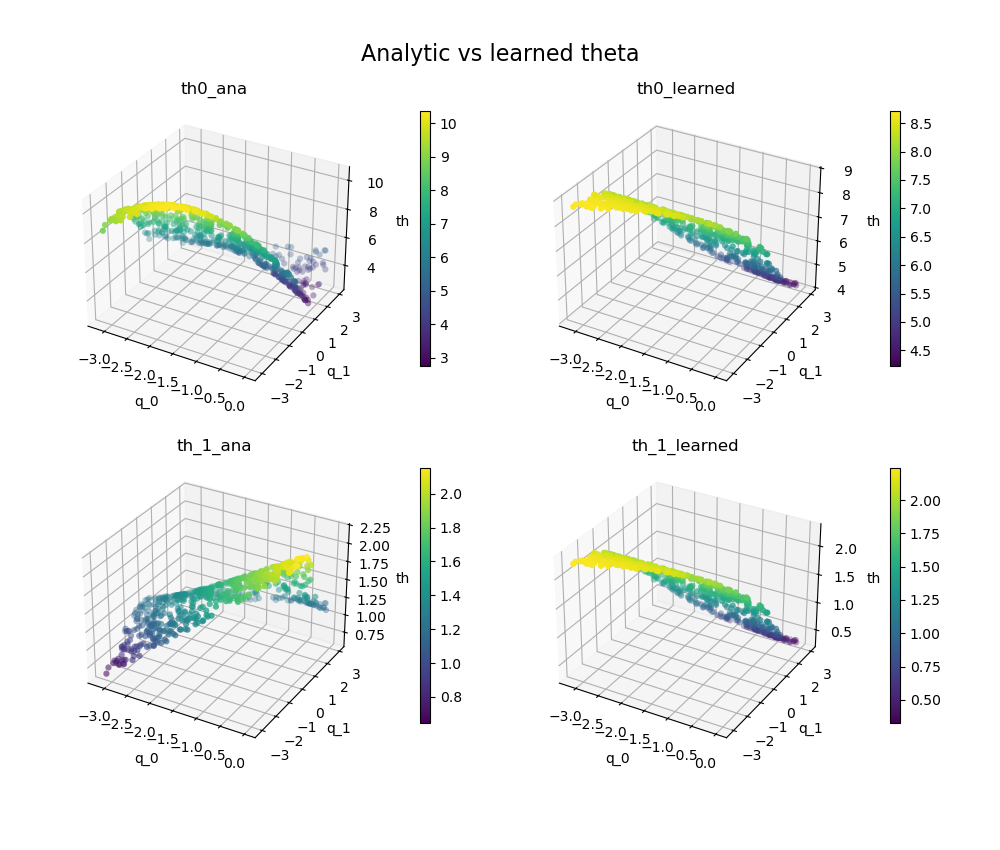

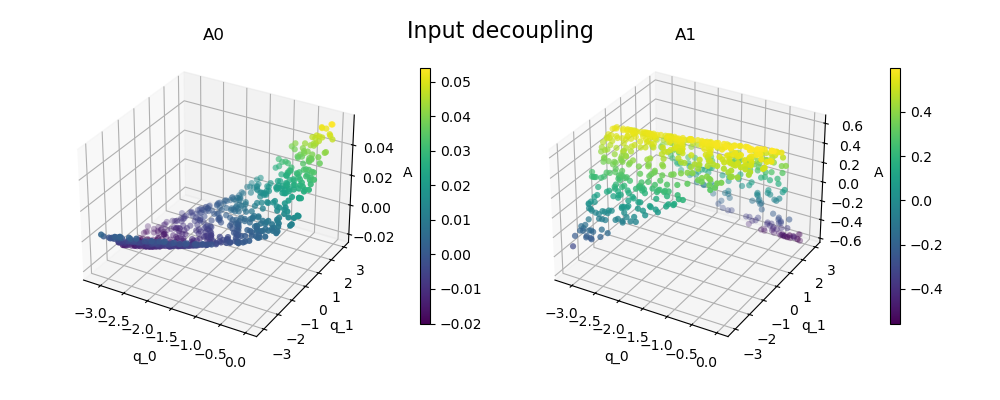

Percentage of abs(A_0) > 0.6: 0.0 %
Percentage of abs(A_1) < 0.3: 33.0 %


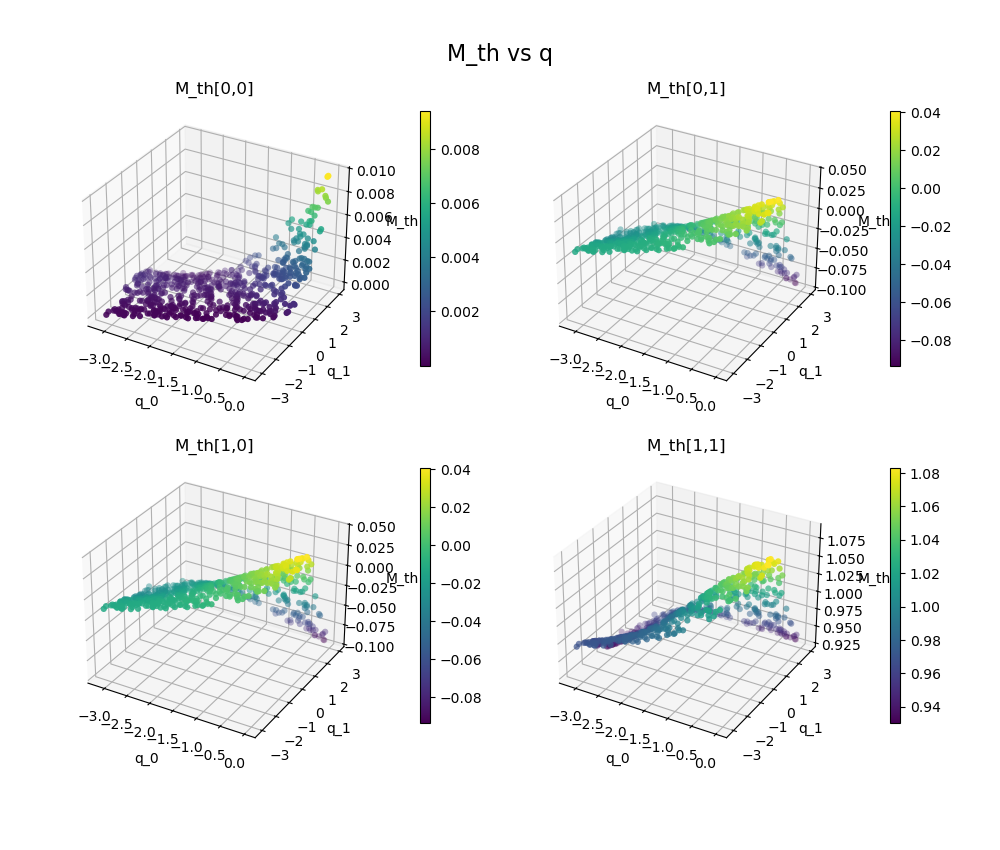

Percentage of abs(M_00) > 1.0: 0.0 %
Percentage of abs(M_01) < 0.2: 100.0 %
Percentage of abs(M_11) > 1.0: 31.833333333333332 %


In [ ]:
%matplotlib widget

folder_path = os.path.join(dir_path, "performance_plots_" + str(file_counter))

#q0_split = (-torch.pi, torch.pi)
plt.ion()
#model = autoencoders.Autoencoder_double(rp).to(device)
#model_location = 'Models/Split_AEs/Lumped_Mass_202503051257.pth'
#model.load_state_dict(torch.load(model_location, weights_only=True))
plot_points = mask_points(q0_split, clockwise = train_clockwise)
plot_dataset = make_dataset(plot_points)
plot_dataloader = make_plot_dataloader(plot_dataset)
plot_model_performance(model, plot_dataloader, folder_path)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

model = autoencoders.Autoencoder_double(rp).to(device)  # Initialize model architecture
model.load_state_dict(torch.load("Models/NN_202505141642/NN_202505141642_0.pth", weights_only=True, map_location=device))  # Load weights
#"Models", dir_name, dir_name + "_" + str(file_counter-1) + ".pth")
model_ana = autoencoders.Analytic_transformer(rp)

models = [model_ana, model]
model_names = ["Analytic", "Neural Network"]
dir_path = os.path.join(os.getcwd(), "Models", "NN_202505141642")
dir_path = dir_path
file_counter = 0


def check_clockwise_vectorized(q):
		"""
		Expects q to be a tensor of shape (N,2) where each row is [q0, q1].
		Returns two boolean masks: (cw_mask, ccw_mask), where:
			- cw_mask[i] is True if the i-th configuration is elbow clockwise.
			- ccw_mask[i] is True if the i-th configuration is elbow counterclockwise.
		
		The logic is as follows (from your original function):
			If q1 lies between q0 and q0+π, or between q0-2π and q0-π, then the configuration
			is considered counterclockwise. Otherwise it is clockwise.
		"""
		q0 = q[:, 0]
		q1 = q[:, 1]
		cond_ccw = ((q1 >= q0) & (q1 <= q0 + torch.pi))
		cw_mask = ~cond_ccw
		ccw_mask = cond_ccw
		return cw_mask, ccw_mask


# Define the number of grid points along each dimension.
n_points = 200

for i in range(2):

	if i == 0:
		# Create 1D tensors for q0 and q1 in the range [-pi, pi]
		q0_vals = torch.linspace(-np.pi, np.pi, n_points)
		q1_vals = torch.linspace(-np.pi, 2*np.pi, n_points)

		theta_xy_fig_path = os.path.join(dir_path, "theta_vs_q_full" + str(file_counter) + ".png")
	if i == 1:
		q0_vals = torch.linspace(training_data.q0_low, training_data.q0_high, n_points)
		q1_vals = torch.linspace(training_data.q1_low, training_data.q1_high, n_points)		
		theta_xy_fig_path = os.path.join(dir_path, "theta_vs_q_partial" + str(file_counter) + ".png")

	# Create a 2D grid (meshgrid) of q values.
	# (Note: using indexing='ij' so that the first axis corresponds to q0 and the second to q1)
	q0_grid, q1_grid = torch.meshgrid(q0_vals, q1_vals, indexing='ij')

	# Stack the grid to get a tensor of shape (n_points*n_points, 2)
	q_grid = torch.stack([q0_grid.flatten(), q1_grid.flatten()], dim=1).to(device)

	# === Compute theta0 and theta1 using the analytic encoder functions ===
	# We use torch.vmap to evaluate the functions over the batch of q values.
	# Note: encoder_theta_0_ana and encoder_theta_1_ana each return a tuple (theta, theta).

	if train_clockwise:
			raise ValueError("This plotter currently only supports plotting counterclockwise performance. Should be an easy fix")


	fig, axes = plt.subplots(2, 2, figsize=(10, 8.5))
	for i, (model, model_name) in enumerate(zip(models, model_names)):

			theta_out = model.encoder_vmap(q_grid)
			#theta_out = torch.vmap(model.encoder)(q_grid)

			theta0 = theta_out[:, 0]
			theta1 = theta_out[:, 1]

			# Since q1_grid and q2_grid are already on a mesh, we can compute x_end and y_end elementwise.
			x_end = rp["l0"] * torch.cos(q_grid[:, 0]) + rp["l1"] * torch.cos(q_grid[:, 1])
			y_end = rp["l0"] * torch.sin(q_grid[:, 0]) + rp["l1"] * torch.sin(q_grid[:, 1])

			# --- Determine configuration (clockwise vs. counterclockwise) for each q ---
			cw_mask, ccw_mask = check_clockwise_vectorized(q_grid)
			# Counterclockwise points
			x_end_ccw   = x_end[ccw_mask].detach().cpu().numpy()
			y_end_ccw   = y_end[ccw_mask].detach().cpu().numpy()
			theta0_ccw  = theta0[ccw_mask].detach().cpu().numpy()
			theta1_ccw  = theta1[ccw_mask].detach().cpu().numpy()
			thetas = [theta0_ccw, theta1_ccw]

			l_total = rp["l0"] + rp["l1"]

			for j in range(2):
					sc = axes[i, j].scatter(x_end_ccw, y_end_ccw, c=thetas[j], cmap='viridis', s=5)
					axes[i, j].set_title("th_" + str(j) + " - " + model_names[i])
					axes[i, j].set_xlabel("x")
					axes[i, j].set_ylabel("y")
					plt.colorbar(sc, ax=axes[i, j])
					axes[i, j].set_xlim((-l_total, l_total))
					axes[i, j].set_ylim((-l_total, l_total))


			#sc4 = axes[1].scatter(x_end_ccw, y_end_ccw, c=theta2_ccw, cmap='viridis', s=5)
			#axes[1].set_title("Theta1 - Counterclockwise")
			#axes[1].set_xlabel("x")
			#axes[1].set_ylabel("y")
			#plt.colorbar(sc4, ax=axes[1])

	plt.tight_layout()
	plt.savefig(theta_xy_fig_path)
	plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Models/NN_202505141642/NN_202505141642_0.pth'